### 【 D0123_work_이준기 】

[ 2026-01-23] 과제

NYC Taxi Dataset

① 요금(Fare Amount) 회귀 예측  	 => MAE

② 장거리 Trip 분류 			 => F1

③ 공항 Trip 여부 분류 			 => F1

④ Trip Duration(이동 시간) 회귀 예측 => MAE

### 순서도 (계획)
1. 과제 번호 선택 (3번)
2. 데이터 확인 (컬럼 확인, 어떤 컬럼 사용할지 등)
3. 4개 데이터 전부 불러와서 전처리 진행
4. 공항 Trip 라벨 생성 (공항 좌표 정의)
5. Feature 선택 및 데이터셋 구성
6. 모델 설계 및 학습
7. 모델 평가
8. 결과 분석 및 해석
9. 결론 및 향후 개선 방향

In [16]:
## -------------------------------------------------------------------------------
## 모듈 로딩
## -------------------------------------------------------------------------------
import pandas as pd
import numpy as np

In [2]:
## -------------------------------------------------------------------------------
## 데이터 확인
## -------------------------------------------------------------------------------
DATA_FILE_TEST = '../D0123/Data/yellow_tripdata_2015-01.csv'

df_T = pd.read_csv(DATA_FILE_TEST)

df_T.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [3]:
df_T.shape

(12748986, 19)

- 총 컬럼 개수 19개
- 각 컬럼 의미 및 선택 여부
1. VendorID : 택시 회사 ID
2. tpep_pickup_datetime : 승차 시각
3. tpep_dropoff_datetime : 하차 시각
4. passenger_count : 승객 수
5. trip_distance : 이동 거리
6. pickup_longitude : 승차 경도
7. pickup_latitude : 승차 위도
8. RateCodeID : 요금 정책 코드
9. store_and_fwd_flag : 서버 전송 지연 여부
10. dropoff_longitude : 하차 경도
11. dropoff_latitude : 하차 위도
12. payment_type : 결제 방식
13. fare_amount : 기본 요금
14. extra : 추가 요금
15. mta_tax : 세금
16. tip_amount : 팁
17. tolls_amount : 톨게이트 요금
18. improvement_surcharge : 추가 요금
19. total_amount : 총 요금

- 사용할 컬럼
1. passenger_count : 승객 수
2. trip_distance : 이동 거리
3. pickup_longitude : 승차 경도
4. pickup_latitude : 승차 위도
5. dropoff_longitude : 하차 경도
6. dropoff_latitude : 하차 위도

-> 승차 시각과 하차 시각은 가공해서 탑승 시간으로 새로운 컬럼 생성 예정

In [33]:
## -------------------------------------------------------------------------------
## 전처리 함수 생성
## -------------------------------------------------------------------------------
def preprocessing(df):

    ## 선택 컬럼만 추출하기
    use_cols = [
    'passenger_count',
    'trip_distance',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
    ]
    df = df[use_cols]

    ## 결측치 제거
    df = df.dropna(subset=use_cols)

    ## 승객 수가 1보다 작거나 6보다 큰 이상치 제거
    cond1 = (df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)
    df = df[cond1]

    ## 이동 거리가 0인 이상치 제거
    cond2 = df['trip_distance'] > 0
    df = df[cond2]

    ## 뉴욕시 범위를 벗어난 승차 좌표값은 이상치로 판단하여 제거
    cond3 = (df['pickup_longitude'].between(-74.3, -73.6)) & (df['pickup_latitude'].between(40.5, 41.0))
    df = df[cond3]

    ## 뉴욕시 범위를 벗어난 하차 좌표값은 이상치로 판단하여 제거
    cond4 = (df['dropoff_longitude'].between(-74.3, -73.6)) & (df['dropoff_latitude'].between(40.5, 41.0))
    df = df[cond4]


    return df.reset_index(drop=True)

In [27]:
## -------------------------------------------------------------------------------
## 공항 반경 내인지 여부 라벨 생성하는 함수
## -------------------------------------------------------------------------------
def is_airport_trip(df):

    # 뉴욕시 공항들
    # John F. Kennedy Intl. Airport : JFK 
    # LaGuardia Airport             : LGA
    # Newark Liberty Intl. Airport  : EWR

    AIRPORTS  = {
        "JFK" : (40.6413, -73.7781),
        "LGA" : (40.7769, -73.8740),
        "EWR" : (40.6895, -74.1745)
    }

    AIRPORT_RADIUS = 3000   # 미터 단위


    ## ----------------------------------------------------------
    ## 위도, 경도를 미터 단위 거리로 변환하는 함수
    ## ----------------------------------------------------------
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371000 # 지구 반지름 (미터)

        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

        dlat = lat2 - lat1
        dlon = lon2 - lon1
 
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))

        return R * c
    

    ## ----------------------------------------------------------
    ## 공항 반경 여부 판단
    ## ----------------------------------------------------------
    def check_airport(row):
        pi_lat, pi_lon = row['pickup_latitude'], row['pickup_longitude']
        dr_lat, dr_lon = row['dropoff_latitude'], row['dropoff_longitude']

        for lat, lon in AIRPORTS.values():
            if haversine(pi_lat, pi_lon, lat, lon) <= AIRPORT_RADIUS:
                return 1
            if haversine(dr_lat, dr_lon, lat, lon) <= AIRPORT_RADIUS:
                return 1
        return 0
    
    
    # 라벨 컬럼 생성
    df['is_airport_trip'] = df.apply(check_airport, axis=1)
    
    return df

In [20]:
df_Tc = df_T.copy()

In [ ]:
## ----------------------------------------------------------
## 전처리 적용 및 확인
## ----------------------------------------------------------
df_Tc = preprocessing(df_Tc)
df_Tc = is_airport_trip(df_Tc)
print(df_Tc.shape)
df_Tc.head()

(12426689, 7)


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,is_airport_trip
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,0
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,0
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,0
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,0
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,0


- 전처리 테스트 결과 12,748,986행 -> 12,426,689행.
- 322,297개의 이상치 행 정상적으로 삭제 확인 

In [ ]:
## ----------------------------------------------------------
## 비율 확인
## ----------------------------------------------------------
df_Tc['is_airport_trip'].value_counts(normalize=True)

is_airport_trip
0    0.942383
1    0.057617
Name: proportion, dtype: float64

< 실습 >

In [117]:
## ----------------------------------------------------------
## 모듈 로딩
## ----------------------------------------------------------
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from   torch.optim.lr_scheduler import ReduceLROnPlateau

from   torch.utils.data import Dataset, TensorDataset, DataLoader
from   torch.utils.data import random_split
from   sklearn.model_selection import train_test_split

import util_func as uf

import pandas as pd

In [32]:
## ----------------------------------------------------------
## 데이터 준비
## ----------------------------------------------------------
DATA_FILE1 = '../D0123/Data/yellow_tripdata_2015-01.csv'
DATA_FILE2 = '../D0123/Data/yellow_tripdata_2016-01.csv'
DATA_FILE3 = '../D0123/Data/yellow_tripdata_2016-02.csv'
DATA_FILE4 = '../D0123/Data/yellow_tripdata_2016-03.csv'

df1 = pd.read_csv(DATA_FILE1)
df2 = pd.read_csv(DATA_FILE2)
df3 = pd.read_csv(DATA_FILE3)
df4 = pd.read_csv(DATA_FILE4)

df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

df.shape

(47248845, 20)

In [34]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RatecodeID
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1.0,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,NaN
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1.0,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,NaN
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1.0,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,NaN
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1.0,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,NaN
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1.0,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,NaN


In [35]:
## ----------------------------------------------------------
## 전처리 적용 및 확인
## ----------------------------------------------------------
df = preprocessing(df)
df = is_airport_trip(df)
print(df.shape)
df.head()

(46206008, 7)


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,is_airport_trip
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,0
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,0
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,0
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,0
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,0


데이터 개수 : 46,206,008개

In [96]:
## ----------------------------------------------------------
## 데이터 샘플링 (학습 속도 개선)
## ----------------------------------------------------------
df_s = df.sample(n=3_000_000, random_state=42)

print(df_s.shape)

(3000000, 7)


In [97]:
## ----------------------------------------------------------
## 비율 확인
## ----------------------------------------------------------
df_s['is_airport_trip'].value_counts(normalize=True)

is_airport_trip
0    0.935417
1    0.064583
Name: proportion, dtype: float64

In [98]:
## ----------------------------------------------------------
## 데이터 나누기
## ----------------------------------------------------------
featureDF = df_s[df_s.columns[:-1]]
targetDF  = df_s[df_s.columns[-1:]]

In [99]:
## ----------------------------------------------------------
## 데이터셋 클래스 정의
## ----------------------------------------------------------
class TestDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.xTS = torch.tensor(featureDF.values, dtype=torch.float32)
        self.yTS = torch.tensor(targetDF.values, dtype=torch.float32) 
        self.length = featureDF.shape[0]

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.xTS[idx], self.yTS[idx]

In [100]:
## ----------------------------------------------------------
## 학습용/검증용/테스트용 데이터셋 분리
## ----------------------------------------------------------
x_train, x_test, y_train, y_test   = train_test_split(featureDF, targetDF,
                                                      test_size=0.2,
                                                      random_state=10)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                                      test_size=0.2,
                                                      random_state=10)

In [101]:
## ----------------------------------------------------------
## 데이터셋 생성
## ----------------------------------------------------------
trainDS  = TestDataset(x_train, y_train)
validDS  = TestDataset(x_valid, y_valid)
testDS   = TestDataset(x_test, y_test)

print(len(trainDS), len(validDS), len(testDS))

1920000 480000 600000


In [102]:
## ----------------------------------------------------------
## 모델 클래스 정의
## ----------------------------------------------------------
class Test(nn.Module):
    def __init__(self, in_out, out_out):
        super().__init__()
        self.fc1 = nn.Linear(in_out, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, out_out)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return self.out(out)

학습 진행 <hr>

In [157]:
## 설정값들 
EPOCHS = 20
BS = 4096
LR = 0.1

## 저장 모델 파일명  => 
import os
os.makedirs("../Models", exist_ok=True)
ALL_MODEL     = '../Models/AirportTrip_model.pt'    ## 모델 전체 확장자    pt
WEIGHTS_MODEL = '../Models/AirportTrip_weights'     ## 파라미터 저장 확장자 pth

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [158]:
## ----------------------------------------------------------
## 인스턴스들
## ----------------------------------------------------------
from torchmetrics.classification import F1Score, Recall
model       = Test(in_out=x_train.shape[1], out_out=1).to(DEVICE)
loss_fn     = nn.BCEWithLogitsLoss()
optimizer   = optim.Adam(model.parameters(), lr= LR)

trainDL     = DataLoader(trainDS, batch_size=BS, shuffle=True)
validDL     = DataLoader(validDS, batch_size=BS) 
testDL      = DataLoader(testDS,  batch_size=BS)

## 스케쥴러 : 검증데이터의 성능지표에 대한 기준 loss, acc
scheduler   = ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [ ]:
## ----------------------------------------------------------
## 학습 진행
## ----------------------------------------------------------
f1_metric = F1Score(task="binary").to(DEVICE)

BEST_LOSS       = float("inf")  # 파이썬에서 표현 가능한 무한대 값
EARLY_STOP_CNT  = 10

for epoch in range(EPOCHS):

    # =======================
    # Train
    # =======================
    model.train()
    train_loss = 0.0
    f1_metric.reset()

    for x, y in trainDL:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        logits = model(x)              # (B, 1)
        loss   = loss_fn(logits, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        preds = (torch.sigmoid(logits) >= 0.5).int()
        f1_metric.update(preds, y.int())

    train_loss /= len(trainDL.dataset)
    train_f1 = f1_metric.compute().item()


    # =======================
    # Validation
    # =======================
    model.eval()
    valid_loss = 0.0
    f1_metric.reset()

    with torch.no_grad():
        for x, y in validDL:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(x)
            loss   = loss_fn(logits, y)

            valid_loss += loss.item() * x.size(0)

            preds = (torch.sigmoid(logits) >= 0.5).int()
            f1_metric.update(preds, y.int())

    valid_loss /= len(validDL.dataset)
    valid_f1 = f1_metric.compute().item()


    # =======================
    # Scheduler & Save
    # =======================
    scheduler.step(valid_loss)

    if valid_loss < BEST_LOSS:
        BEST_LOSS = valid_loss
        torch.save(model, ALL_MODEL)
        torch.save(
            model.state_dict(),
            f"{WEIGHTS_MODEL}_{epoch:03}_{valid_loss:.5f}.pth"
        )

    # =======================
    # Log
    # =======================
    print(
        f"[{epoch:02d}] "
        f"LOSS train/valid = {train_loss:.5f} / {valid_loss:.5f} | "
        f"F1 train/valid = {train_f1:.4f} / {valid_f1:.4f} | "
        f"LR = {scheduler.get_last_lr()[0]:.6f}"
    )

    # =======================
    # Early Stop
    # =======================
    if scheduler.num_bad_epochs >= scheduler.patience:
        EARLY_STOP_CNT -= 1

    if EARLY_STOP_CNT == 0:
        print("성능 개선 없음 → 조기 종료")
        break


[00] LOSS train/valid = 0.28906 / 0.23979 | F1 train/valid = 0.0040 / 0.0000 | LR = 0.100000
[01] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.100000
[02] LOSS train/valid = 0.23981 / 0.23982 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.100000
[03] LOSS train/valid = 0.23981 / 0.23981 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.100000
[04] LOSS train/valid = 0.23982 / 0.23980 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[05] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[06] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[07] LOSS train/valid = 0.23980 / 0.23980 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[08] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.001000
[09] LOSS train/valid = 0.23979 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.001000
[10] LOSS train/valid = 0.23979 / 0.23979 | F1 train/valid = 0.0000 / 

초기 학습에서는 클래스 불균형으로 인해 모든 샘플을 0으로 예측하는 현상이 발생

In [ ]:
## ----------------------------------------------------------
## 인스턴스 수정
## ----------------------------------------------------------

## 클래스 불균형 완화를 위해 양성 클래스에 가중치를 부여 (음성/양성 비율 기반 계산)
pos_weight = torch.tensor(
    [(len(df) - df['is_airport_trip'].sum()) / df['is_airport_trip'].sum()],
    device=DEVICE
)

## 이진 분류용 손실 함수 (sigmoid + BCE 내부적 포함)            BCE란? : Binary Cross Entropy (이진 교차 엔트로피)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

## Adam 옵티마이저 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
## ----------------------------------------------------------
## 그래프 출력을 위한 빈 리스트 생성
## ----------------------------------------------------------
history = {
    "train_loss": [],
    "val_loss":   [],
    "train_f1":  [],   
    "val_f1":    []
}

In [161]:
## ----------------------------------------------------------
## 학습 진행
## ----------------------------------------------------------
f1_metric = F1Score(task="binary").to(DEVICE)

BEST_F1         = 0.0
EARLY_STOP_CNT  = 5

for epoch in range(EPOCHS):

    # =======================
    # Train
    # =======================
    model.train()
    train_loss = 0.0
    f1_metric.reset()

    for x, y in trainDL:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        logits = model(x)              # (B, 1)
        loss   = loss_fn(logits, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        preds = (torch.sigmoid(logits) >= 0.5).int()
        f1_metric.update(preds, y.int())

    train_loss /= len(trainDL.dataset)
    train_f1 = f1_metric.compute().item()


    # =======================
    # Validation
    # =======================
    model.eval()
    valid_loss = 0.0
    f1_metric.reset()

    with torch.no_grad():
        for x, y in validDL:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(x)
            loss   = loss_fn(logits, y)

            valid_loss += loss.item() * x.size(0)

            preds = (torch.sigmoid(logits) >= 0.5).int()
            f1_metric.update(preds, y.int())

    valid_loss /= len(validDL.dataset)
    valid_f1 = f1_metric.compute().item()


    # =======================
    # Save (F1 기준)
    # =======================
    if valid_f1 > BEST_F1:
        BEST_F1 = valid_f1
        torch.save(model, ALL_MODEL)
        torch.save(
            model.state_dict(),
            f"{WEIGHTS_MODEL}_{epoch:03}_F1_{valid_f1:.4f}.pth"
        )
        EARLY_STOP_CNT = 5
    else:
        EARLY_STOP_CNT -= 1


    # =======================
    # Log
    # =======================
    history["train_loss"].append(train_loss)   
    history["val_loss"].append(valid_loss)     
    history["train_f1"].append(train_f1)      
    history["val_f1"].append(valid_f1)        


    print(
        f"[{epoch+1:02d}] "
        f"LOSS train/valid = {train_loss:.5f} / {valid_loss:.5f} | "
        f"F1 train/valid = {train_f1:.4f} / {valid_f1:.4f}"
    )

    if EARLY_STOP_CNT == 0:
        print("F1 개선 없음 → 조기 종료")
        break


[01] LOSS train/valid = 0.55839 / 0.37009 | F1 train/valid = 0.5667 / 0.6642
[02] LOSS train/valid = 0.37711 / 0.37525 | F1 train/valid = 0.6785 / 0.6371
[03] LOSS train/valid = 0.37665 / 0.36821 | F1 train/valid = 0.6838 / 0.7152
[04] LOSS train/valid = 0.37550 / 0.38363 | F1 train/valid = 0.6870 / 0.7437
[05] LOSS train/valid = 0.37590 / 0.36540 | F1 train/valid = 0.6895 / 0.6908
[06] LOSS train/valid = 0.37521 / 0.36699 | F1 train/valid = 0.6937 / 0.7213
[07] LOSS train/valid = 0.37553 / 0.37114 | F1 train/valid = 0.6945 / 0.6636
[08] LOSS train/valid = 0.37456 / 0.36704 | F1 train/valid = 0.6966 / 0.7175
[09] LOSS train/valid = 0.37428 / 0.36310 | F1 train/valid = 0.6997 / 0.7150
F1 개선 없음 → 조기 종료


클래스 불균형을 고려하여 pos_weight를 적용한 BCEWithLogitsLoss를 사용하였으며,
그 결과 검증 데이터 기준 F1-score 0.74 수준의 안정적인 분류 성능을 달성하였다.

1. 스케줄러를 사용하지 않은 이유
- learning rate scheduler를 적용할 경우, 학습 초반부터 학습률이 과도하게 감소하여 모델이 충분히 학습되지 못하는 현상을 관찰되었다. 특히, 클래스 뷸균형을 고려하여 pos_weight를 적용한 이후에는 고정된 learning rate 환경에서 F1-score가 더 안정적으로 증가하였다.

2. F1-score를 성능 지표로 사용한 이유
- 데이터에서 공항 Trip 여부의 비율이 약 6프로 수준으로 클래스 뷸균형이 매우 심한 이진 분류이다. 이 경우 단순 정확도는 다수 클래스에 편향된 결과를 보일 수 있으므로, Precision과 Recall을 동시에 고려하는 F1-score를 주요 성능 지표로 사용하였다.

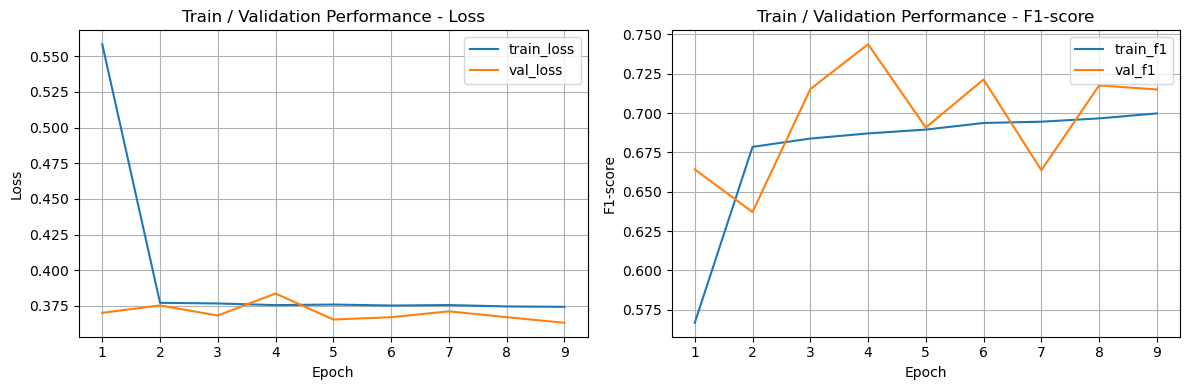

In [162]:
## ----------------------------------------------------------
## 그래프 출력
## ----------------------------------------------------------
uf.plot_history(history, title="Train / Validation Performance")

### 그래프 해석
- train_loss
    - Epoch 1 -> 2 에서 급격히 감소하고 그 이후 완만하게 감소하며 거의 수렴
- val_loss
    - 초반부터 train_loss보다 낮고 전반적으로 안정적

-> 초반 학습이 빠르게 이루어졌고, 안정적인 수렴 구간에 진입. train/val간 큰 차이가 없으므로 과적합은 발생하지 않은 것으로 보인다.

- train_f1
    - Epoch 증가에 따라 꾸준히 상승 0.56 -> 약 0.7
- val_f1
    - 전체적으로 변동성이 크며 Epoch 4에서 최댓값(0.7437)

-> 모델은 학습 데이터에 대해 일관되게 성능이 개선 되었으며 val_f1의 변동성은 데이터의 불균형 때문일 가능성이 크다. Epoch 4가 일반화 성능 기준 최적의 시점이다.

In [163]:
## ----------------------------------------------------------
## Test를 위한 model load
## ----------------------------------------------------------
model = torch.load(ALL_MODEL)
model.to(DEVICE)
model.eval()

C:\Users\KDT\AppData\Local\Temp\ipykernel_20288\4292267156.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(ALL_MODEL)


Test(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [164]:
## ----------------------------------------------------------
## 모델 성능 테스트
## ----------------------------------------------------------
test_loss = 0.0
f1_metric.reset()

with torch.no_grad():
    for x, y in testDL:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)
        loss   = loss_fn(logits, y)

        test_loss += loss.item() * x.size(0)

        preds = (torch.sigmoid(logits) >= 0.5).int()
        f1_metric.update(preds, y.int())

test_loss /= len(testDL.dataset)
test_f1 = f1_metric.compute().item()

print(f"[TEST] LOSS = {test_loss:.5f} | F1 = {test_f1:.4f}")


[TEST] LOSS = 0.38430 | F1 = 0.7412


#### Test 데이터셋에 대해 LOSS = 0.3843, F1 = 0.7412으로 측정되었으며, 이는 val 단계에서의 최고 성능과 유사한 수치이다. 이를 통해 본 모델은 특정 데이터에 과적합되지 않고, 새로운 데이터에 대해서도 안정적인 분류 성능을 보이는 것을 확인하였다. 

In [165]:
## ----------------------------------------------------------
## 공항 Trip 예측 함수 생성
## ----------------------------------------------------------
def predict_airport(model, input_features, device=DEVICE):
    model.eval()

    x = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0)
    x = x.to(device)

    with torch.no_grad():
        logit = model(x)
        prob  = torch.sigmoid(logit).item()
        pred  = 1 if prob >= 0.5 else 0

    return prob, pred


In [ ]:
## ----------------------------------------------------------
## 공항 Trip O, X 샘플 데이터 생성
## ----------------------------------------------------------

# - 사용할 컬럼
# 1. passenger_count   : 승객 수
# 2. trip_distance     : 이동 거리
# 3. pickup_longitude  : 승차 경도
# 4. pickup_latitude   : 승차 위도
# 5. dropoff_longitude : 하차 경도
# 6. dropoff_latitude  : 하차 위도


## 공항 Trip X 샘플 데이터
non_airport_samples = [
    [1, 2.3, -73.9851, 40.7580, -73.9815, 40.7681],  # Times Square → Upper West
    [2, 3.8, -73.9772, 40.7527, -73.9654, 40.7615],  # Midtown 이동
    [1, 1.2, -73.9910, 40.7306, -73.9876, 40.7359],  # SoHo 근처
    [3, 5.1, -73.9442, 40.6782, -73.9565, 40.6676],  # Brooklyn 내부
    [2, 4.0, -73.9712, 40.7831, -73.9601, 40.7754],  # Upper East Side
]

## 공항 Trip O 샘플 데이터
airport_samples = [
    [1, 18.4, -73.9857, 40.7484, -73.7781, 40.6413],  # Manhattan → JFK
    [2, 22.1, -73.9735, 40.7648, -73.7781, 40.6413],  # Midtown → JFK
    [3, 16.7, -73.9550, 40.7128, -73.7781, 40.6413],  # Brooklyn → JFK
    [1, 12.3, -73.9903, 40.7505, -73.8740, 40.7769],  # Manhattan → LGA
    [2, 10.8, -73.9615, 40.7681, -73.8740, 40.7769],  # Upper East → LGA
]

In [167]:
## ----------------------------------------------------------
## 공항 Trip 예측 함수 생성
## ----------------------------------------------------------
## 공항 Trip X 데이터 예측
for x in non_airport_samples:
    prob, pred = predict_airport(model, x)
    print("Non-airport | prob:", round(prob,3), "| pred:", pred)

## 공항 Trip O 데이터 예측
for x in airport_samples:
    prob, pred = predict_airport(model, x)
    print("Airport     | prob:", round(prob,3), "| pred:", pred)

Non-airport | prob: 0.038 | pred: 0
Non-airport | prob: 0.094 | pred: 0
Non-airport | prob: 0.018 | pred: 0
Non-airport | prob: 0.201 | pred: 0
Non-airport | prob: 0.106 | pred: 0
Airport     | prob: 0.988 | pred: 1
Airport     | prob: 0.991 | pred: 1
Airport     | prob: 0.983 | pred: 1
Airport     | prob: 0.957 | pred: 1
Airport     | prob: 0.945 | pred: 1


### 결론 및 향후 개선 방향

택시 이동 데이터를 활용하여 공항 이동 여부를 예측하는 이진 분류 모델을 설계하고 성능을 평가하였다.
모델 학습 과정에서 loss는 초반 이후 안정적으로 수렴하였으며, F1-score 또한 epoch이 증가함에 따라 점점 향상되는 경향을 보였다. 이는 모델이 과적합 없이 데이터의 주요 패턴을 효과적으로 학습하고 있음을 의미한다.

테스트 데이터에 대한 최종 성능은 Test Loss 0.3843, F1-score 0.7412으로 측정되었으며, 이는 클래스 불균형 가능성이 존재하는 상황에서 공항 이동 여부를 비교적 안정적으로 분류할

추가적으로 학습에 사용되지 않은 임의의 샘플 데이터를 통해 모델 예측 결과를 확인한 결과,
일반 도심 이동 데이터에 대해서는 낮은 확률로 공항 이동이 아닌 것을 예측하고,
공항 좌표가 포함된 이동 데이터에 대해서는 매우 높은 확률로 공항 이동을 예측것을 보아,
모델이 위·경도 기반의 공간적 특성을 효과적으로 반영하여 판단하고 있음을 확인할 수 있었다.

다만, 좌표 정보에 대한 의존도가 상대적으로 높아 특정 지역이나 다른 도시 데이터에 대해서는 성능이 제한될 수 있다. 향후에는 공항과의 거리를 명시적으로 추가하거나, 다양한 지역 데이터를 포함한 학습을 통해 모델을 개선할 필요가 있다고 느꼈다.

종합적으로, 이번 과제에서 제안한 모델은 제한된 환경에서도 공항 이동 여부를 효과적으로 분류할 수 있음을 확인하였으며, 실제 교통 데이터 분석 및 이동 패턴 분류 문제에 적용 가능성이 있음을 알 수 있었다.